# Import the libraries


In [2]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import shutil
import os

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


# Download the dataset


In [4]:
path = kagglehub.dataset_download("crawford/cat-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mikhail/.cache/kagglehub/datasets/crawford/cat-dataset/versions/2


# Inspect the dataset

## List the files in the dataset directory


In [5]:
print("Files in the dataset directory:")
for folder in os.listdir(path):
    print(f"Folder {folder} has {len(os.listdir(os.path.join(path, folder)))} files ")

if 'data' not in os.listdir():
    os.mkdir("data")

Files in the dataset directory:
Folder CAT_02 has 0 files 
Folder CAT_03 has 0 files 
Folder CAT_00 has 0 files 
Folder CAT_06 has 0 files 
Folder CAT_05 has 0 files 
Folder CAT_04 has 0 files 
Folder CAT_01 has 0 files 


## Move the images and the .cat files in different folders


In [6]:
if 'images' not in os.listdir("data"):
    os.mkdir("data/images/no_category")
if 'cat_files' not in os.listdir("data"):
    os.mkdir("data/cat_files")

## Move the images and the .cat files in different folders


In [7]:
for folder in os.listdir(path):
    for file in os.listdir(os.path.join(path, folder)):
        if file.endswith(".cat"):
            shutil.move(os.path.join(path, folder, file), os.path.join("data/cat_files", file))
        else:
            shutil.move(os.path.join(path, folder, file), os.path.join("data/images/no_category", file))


In [8]:
## List the files in the images directory
print(f"The images directory has {len(os.listdir('data/images/no_category'))} files")
## List the files in the cat_files directory
print(f"The cat_files directory has {len(os.listdir('data/cat_files'))} files")

The images directory has 9993 files
The cat_files directory has 9993 files


## Data Loading

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [10]:
img_height = 150
img_width = 150
batch_size = 128

In [11]:
cat_folder = "data/images/no_category"

images = []

for filename in os.listdir(cat_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(cat_folder, filename)
        img = Image.open(img_path)
        img = img.resize((img_height, img_width))
        images.append(np.array(img))
images = np.array(images)
# normalisation des pixels entre 0 et 1
images = images.astype("float32") / 255.0

print(f"images shape: {images.shape}")

images shape: (9993, 150, 150, 3)


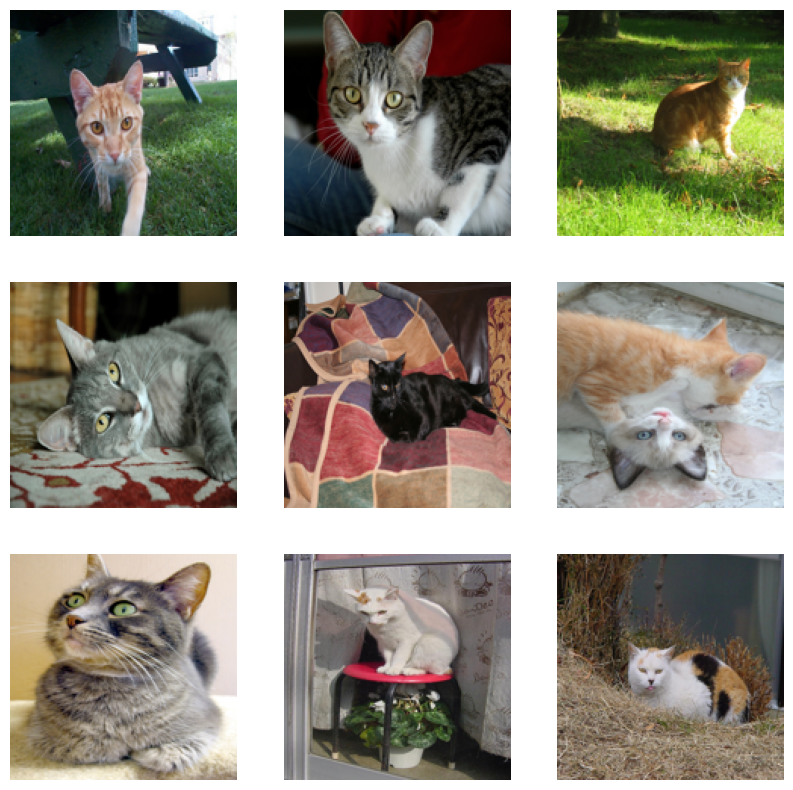

In [18]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

## Train/Test split

In [13]:
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (7994, 150, 150, 3)
x_test shape: (1999, 150, 150, 3)


## Data augmentation

In [14]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])


In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

I0000 00:00:1749376100.174336   30318 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3251 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Un autoencodeur convolutionnel :

- Encodeur (compression) :

3 couches Conv2D + MaxPooling2D réduisent progressivement la taille des images

- Decodeur (reconstruction) :

3 couches Conv2D + UpSampling2D agrandissent progressivement pour recréer l’image originale

La couche finale Conv2D avec activation sigmoid pour produit une image RGB normalisée

In [24]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Resizing
from tensorflow.keras.models import Model


input_img = Input(shape=(150,150,3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = Resizing(150, 150)(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='nadam', loss='mse')

In [25]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

In [26]:
history = autoencoder.fit(x_train, x_train, 
                        epochs=150,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test))

Epoch 1/150
63/63 [==============================] - 4s 46ms/step - loss: 0.0518 - val_loss: 0.0307
Epoch 2/150
63/63 [==============================] - 2s 40ms/step - loss: 0.0250 - val_loss: 0.0206
Epoch 3/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0196 - val_loss: 0.0161
Epoch 4/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0165 - val_loss: 0.0144
Epoch 5/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0150 - val_loss: 0.0139
Epoch 6/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 7/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 8/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 9/150
63/63 [==============================] - 2s 38ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 10/150
63/63 [==============================] - 3s 40ms/step - loss: 0.0120 - val_loss: 0.0122

## Reconstruction visualization

1/1 [==============================] - 0s 70ms/step


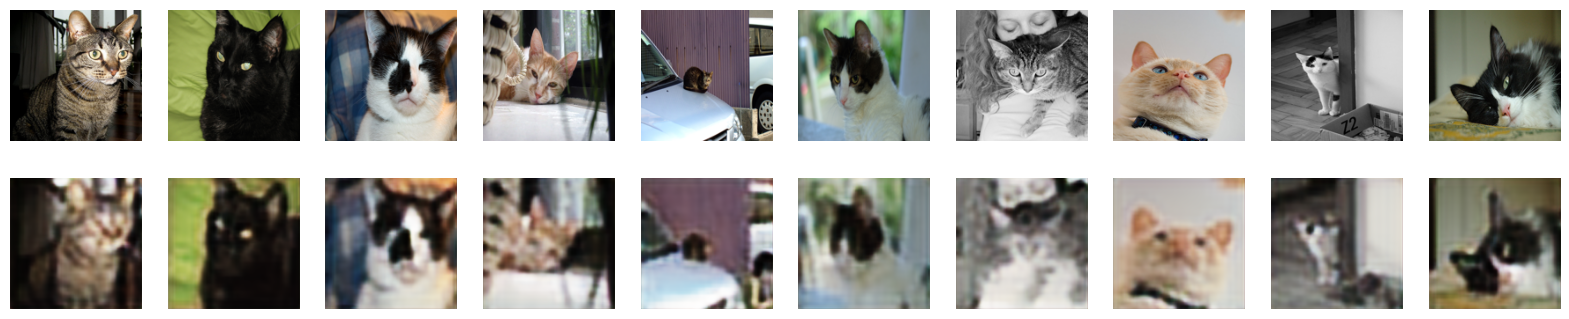

In [27]:
original_images = x_test[:10]
reconstructed_images = autoencoder.predict(original_images)

plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(original_images[i])
    plt.axis("off")

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed_images[i])
    plt.axis("off")
plt.show()

## Denoising Autoencoder (DAE)

Entraînement avec le même autoencoder mais avec une image bruitée en entrée et comme cible l'image propre en sortie.

In [16]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [17]:
print(x_train_noisy.shape, x_train.shape)
print(x_train_noisy.dtype, x_train.dtype)

# Sanity check : aucune valeur NaN
print(np.isnan(x_train_noisy).sum())
print(np.isnan(x_train).sum())


(7994, 150, 150, 3) (7994, 150, 150, 3)
float32 float32
0
0


In [19]:
autoencoder.fit(x_train_noisy, 
                x_train, 
                validation_data=(x_test_noisy, x_test),
                epochs=300,
                batch_size=batch_size,
                shuffle=True
)

Epoch 1/300
63/63 [==============================] - 7s 47ms/step - loss: 0.0471 - val_loss: 0.0257
Epoch 2/300
63/63 [==============================] - 2s 37ms/step - loss: 0.0239 - val_loss: 0.0256
Epoch 3/300
63/63 [==============================] - 2s 37ms/step - loss: 0.0189 - val_loss: 0.0164
Epoch 4/300
63/63 [==============================] - 2s 38ms/step - loss: 0.0165 - val_loss: 0.0143
Epoch 5/300
63/63 [==============================] - 2s 37ms/step - loss: 0.0152 - val_loss: 0.0138
Epoch 6/300
63/63 [==============================] - 2s 37ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 7/300
63/63 [==============================] - 2s 37ms/step - loss: 0.0135 - val_loss: 0.0139
Epoch 8/300
63/63 [==============================] - 2s 37ms/step - loss: 0.0128 - val_loss: 0.0119
Epoch 9/300
63/63 [==============================] - 2s 38ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 10/300
63/63 [==============================] - 2s 38ms/step - loss: 0.0123 - val_loss: 0.0129

1/1 [==============================] - 0s 93ms/step


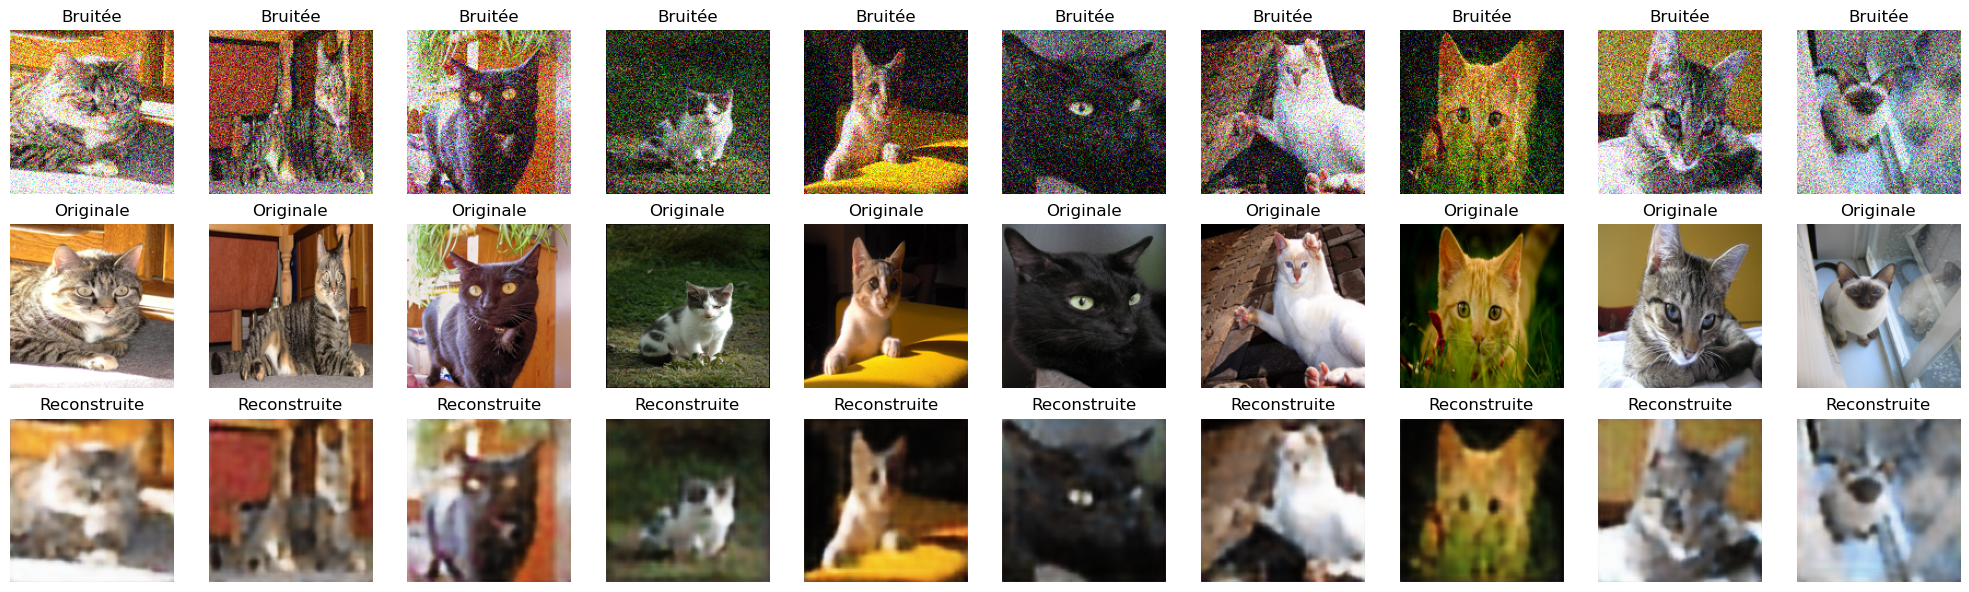

In [20]:
num_images = 10
indices = np.random.choice(len(x_test), num_images, replace=False)

# Image bruitée
noisy_imgs = x_test_noisy[indices]
# Image originale
clean_imgs = x_test[indices]
# Image reconstruite
reconstructed_imgs = autoencoder.predict(noisy_imgs)

plt.figure(figsize=(20, 6))
for i in range(num_images):
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(noisy_imgs[i])
    plt.title("Bruitée")
    plt.axis("off")

    ax = plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(clean_imgs[i])
    plt.title("Originale")
    plt.axis("off")

    ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(reconstructed_imgs[i])
    plt.title("Reconstruite")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Open-Source Model

In [19]:
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe = pipe.to("cuda")
#url = "https://huggingface.co/datasets/patrickvonplaten/images/resolve/main/aa_xl/000000009.png"

init_image = x_train_noisy[0]  # Use the first noisy image as the initial image
prompt = ""
image = pipe(prompt, image=init_image).images

100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


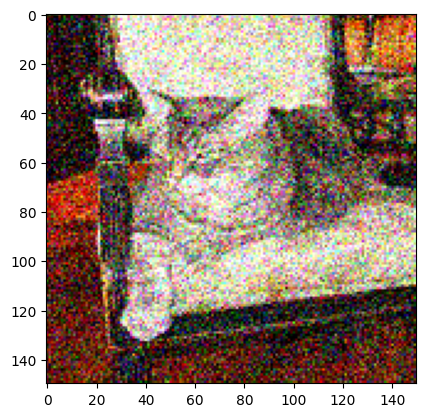

In [21]:
plt.imshow(x_train_noisy[0])

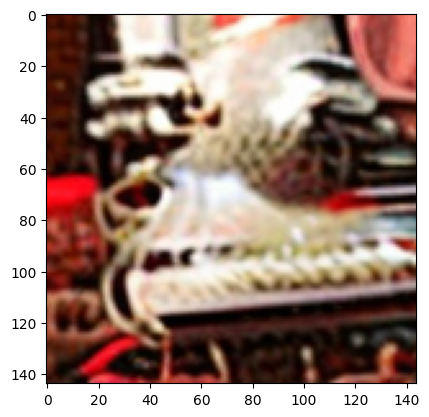

In [20]:
plt.imshow(image[0])